In [1]:
import warnings
warnings.simplefilter("ignore", category=FutureWarning)

In [2]:
import numpy as np
import pandas as pd
from catboost import CatBoostRegressor
from sklearn.model_selection import cross_val_score, RepeatedStratifiedKFold, train_test_split
from sklearn.metrics import classification_report 
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import classification_report, confusion_matrix, make_scorer, f1_score, ConfusionMatrixDisplay
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
import seaborn as sns
import matplotlib.pyplot as plt

from evc import BayesianEvaluation # Importa a library do Prof Verri

from cancer_estimator_model import datasets

# Carregar o dataset 
df = datasets.get_integrated_dataset()
display(df.head(10).T)
df.info()

,0,1,2,3,4,5,6,7,8,9
AGE,69.0,74.0,59.0,63.0,63.0,75.0,52.0,51.0,68.0,53.0
SMOKING,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0
YELLOW_FINGERS,1.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0
ANXIETY,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0
PEER_PRESSURE,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
CHRONIC_DISEASE,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
FATIGUE,1,1,1,0,0,1,1,1,1,0
ALLERGY,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0
WHEEZING,1.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0
ALCOHOL_CONSUMING,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 318109 entries, 0 to 318108
Data columns (total 55 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   AGE                    1309 non-null    float64
 1   SMOKING                1309 non-null    float64
 2   YELLOW_FINGERS         1309 non-null    float64
 3   ANXIETY                309 non-null     float64
 4   PEER_PRESSURE          309 non-null     float64
 5   CHRONIC_DISEASE        309 non-null     float64
 6   FATIGUE                318109 non-null  int64  
 7   ALLERGY                309 non-null     float64
 8   WHEEZING               1309 non-null    float64
 9   ALCOHOL_CONSUMING      309 non-null     float64
 10  COUGHING               318109 non-null  int64  
 11  SHORTNESS_OF_BREATH    318109 non-null  int64  
 12  SWALLOWING_DIFFICULTY  318109 non-null  int64  
 13  CHEST_PAIN             318109 non-null  int64  
 14  LUNG_CANCER_RISK       1309 non-null

In [3]:
# Dividir o conjunto de dados em features (X) e variável alvo (y)
X = df.drop(columns=['LUNG_CANCER_RISK','COUNTRY'])
y = df['LUNG_CANCER_RISK']

# Tratar valores ausentes nas colunas categóricas
categorical_cols = X.select_dtypes(include=['object']).columns.tolist()
for col in categorical_cols:
    X[col].fillna('missing', inplace=True)

# Dividir o conjunto de dados em train and test
X_train = X[X.SOURCE != 3]  # dropa os dados que tem a source 3 (dataset covid)
X_test = X[X.SOURCE == 3]   # coloca somente os dados com a source 3 no teste (dataset covid)
y_train = y[X.SOURCE != 3].astype(float)  # dropa os dados que tem a source 3 (dataset covid) na target


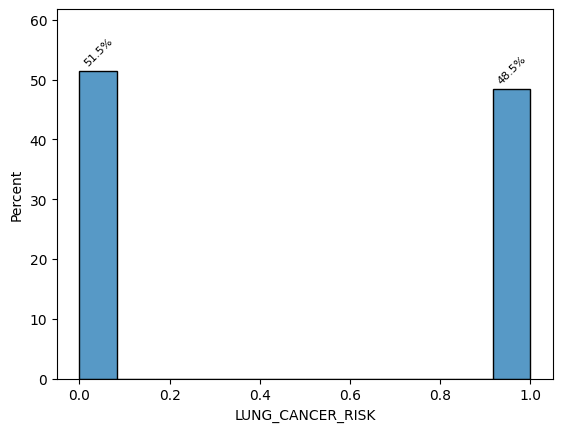

In [4]:
def plot_y_distribution(y):
    # Criando distribuição da variável resposta estimada
    ax = sns.histplot(y, stat='percent')
    
    
    # add annotations
    for c in ax.containers:
    
        # custom label calculates percent and add an empty string so 0 value bars don't have a number
        labels = [f'{w:0.1f}%' if (w := v.get_height()) > 0 else '' for v in c]
    
        ax.bar_label(c, labels=labels, label_type='edge', fontsize=8, rotation=45, padding=2)
        
        ax.margins(y=0.2)
    plt.show()
plot_y_distribution(y_train)

In [5]:
# Cross validation with catboost regression

In [6]:
# Criar o modelo CatBoostRegressor
model_cat = CatBoostRegressor(
    iterations=500, 
    depth=6,
    eval_metric="RMSE",  # Métrica apropriada para regressão
    learning_rate=0.1, 
    cat_features=categorical_cols,  # Passar as colunas categóricas
    verbose=100
)

# Definir um limiar de decisão para converter previsões contínuas em classes
decision_threshold = 0.6

def custom_scoring(y_true, y_pred):
    y_pred_class = (y_pred >= decision_threshold).astype(int)  # Converter previsões contínuas para classes com base no limiar
    report = classification_report(y_true, y_pred_class)
    #cm = confusion_matrix(y_true, y_pred_class)
    #disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    #print(report)
    #disp.plot(cmap=plt.cm.Blues)
    #plt.show()
    return f1_score(y_true, y_pred_class)

# Criar o objeto de validação cruzada estratificada
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=10, random_state=0)


0:	learn: 0.4643735	total: 161ms	remaining: 1m 20s
100:	learn: 0.0802966	total: 282ms	remaining: 1.11s
200:	learn: 0.0479336	total: 408ms	remaining: 606ms
300:	learn: 0.0331239	total: 540ms	remaining: 357ms
400:	learn: 0.0271543	total: 686ms	remaining: 169ms
499:	learn: 0.0241094	total: 826ms	remaining: 0us
0:	learn: 0.4639091	total: 3ms	remaining: 1.5s
100:	learn: 0.0892126	total: 248ms	remaining: 981ms
200:	learn: 0.0551754	total: 389ms	remaining: 579ms
300:	learn: 0.0390403	total: 528ms	remaining: 349ms
400:	learn: 0.0307671	total: 671ms	remaining: 166ms
499:	learn: 0.0266157	total: 811ms	remaining: 0us
0:	learn: 0.4648148	total: 2.84ms	remaining: 1.42s
100:	learn: 0.0869761	total: 278ms	remaining: 1.1s
200:	learn: 0.0534384	total: 512ms	remaining: 762ms
300:	learn: 0.0361959	total: 655ms	remaining: 433ms
400:	learn: 0.0294809	total: 797ms	remaining: 197ms
499:	learn: 0.0257272	total: 1s	remaining: 0us
0:	learn: 0.4690320	total: 2.87ms	remaining: 1.43s
100:	learn: 0.0888712	total: 2

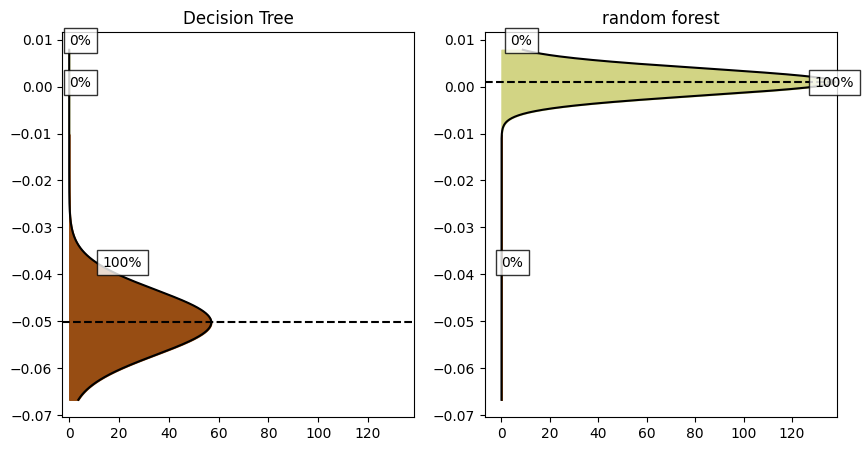

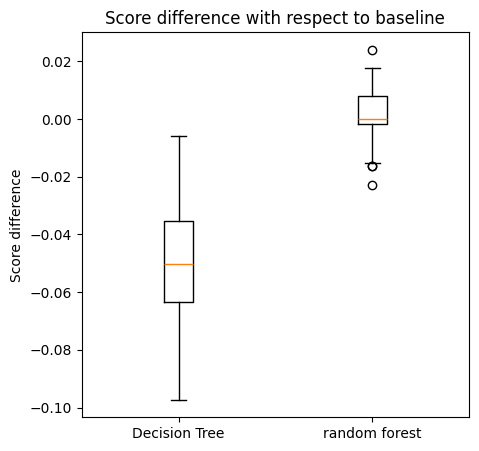

In [7]:
# Create baseline pipeline

baseline = Pipeline([
        ('catboost', model_cat)
    ])


competitors = [
    ('Decision Tree', Pipeline([
    ('Decision Tree', DecisionTreeClassifier(max_depth=2, random_state=0))
])),
    ('random forest', Pipeline([
        ('random forest', RandomForestClassifier(n_estimators=10, random_state=0))
    ])) 
]
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=10, random_state=0)

baseline_score = cross_val_score(baseline, X_train, y_train, cv=cv, scoring=make_scorer(custom_scoring))
competitors_score = [
        (name, cross_val_score(competitor, X_train, y_train, cv=cv,
            scoring=make_scorer(custom_scoring))) for name, competitor in competitors]

be = BayesianEvaluation(baseline_score, rope=0.01)

be.plot(competitors_score)

# Now plot a boxplot of the difference of the scores.

scores = [score - baseline_score for name, score in competitors_score]
names = [name for name, score in competitors_score]

from matplotlib import pyplot as plt

fig, ax = plt.subplots(figsize=(5, 5))
ax.boxplot(scores)
ax.set_xticklabels(names)
ax.set_ylabel('Score difference')
ax.set_title('Score difference with respect to baseline')

plt.show()

0:	learn: 0.4639966	total: 1.82ms	remaining: 910ms
100:	learn: 0.0892585	total: 162ms	remaining: 641ms
200:	learn: 0.0546064	total: 329ms	remaining: 489ms
300:	learn: 0.0382046	total: 501ms	remaining: 331ms
400:	learn: 0.0304764	total: 712ms	remaining: 176ms
499:	learn: 0.0257253	total: 935ms	remaining: 0us


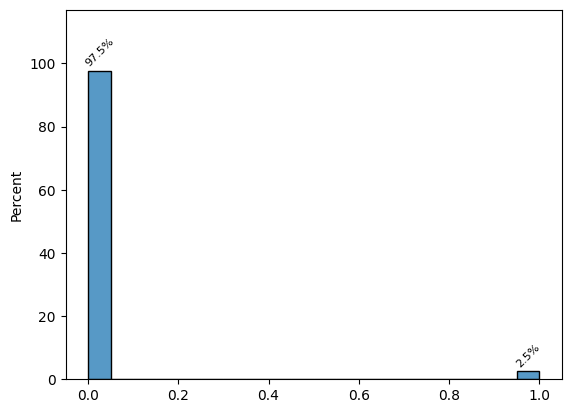

In [8]:
# Ajustar o modelo aos dados de treino completos (modelo catboost)
model_cat.fit(X_train, y_train)

# Fazer a predição no conjunto de dados de teste
y_pred = model_cat.predict(X_test)
y_pred_class = (y_pred >= decision_threshold).astype(int)  # Converter previsões contínuas para classes

plot_y_distribution(y_pred_class)

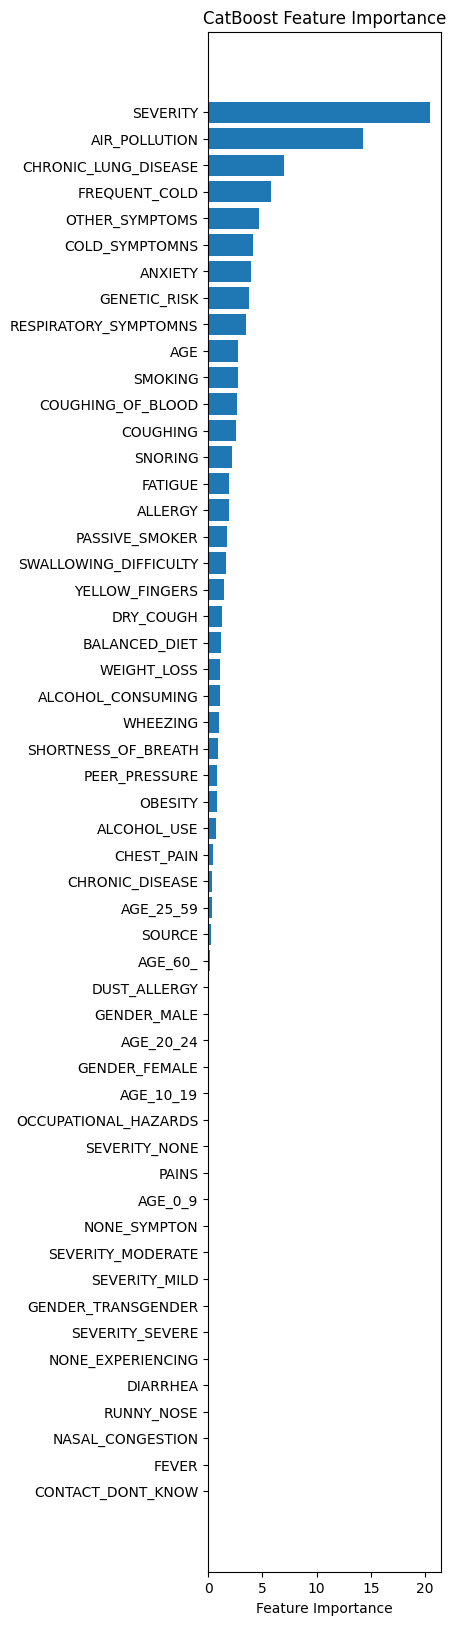

In [9]:
# plot feature importance
feature_importance = model_cat.get_feature_importance(type='FeatureImportance')
feature_names = model_cat.feature_names_
sorted_idx = feature_importance.argsort()

plt.figure(figsize=(3,20))
plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), [feature_names[i] for i in sorted_idx])
plt.xlabel('Feature Importance')
plt.title('CatBoost Feature Importance')
plt.show()